## 9/7/24

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Definir las constantes
g = 9.8 # gravedad [m/s^2]
p_atm = 101325 # Presión atmosférica [Pa]
beta = 3.67e-3 # Coeficiente de expansion termica [1/K]
T_w = 80.0 + 273.0 # Temperatura de la pared [K]
T_a = 20.0 + 273.0 # Temperatura ambiente [K]
delta_T = T_w - T_a
lambda_f = 0.04 # Coeficiente de friccion [adimensional]
R = 10.0 # Radio de la tuberia [m]
L = 100.0 # Longitud de la tuberia [m]
alpha = 2.2e-5 # Coeficiente de difusividad [m^2/s]
rho_0 = 1.0 # Densidad [kg/m^3]
Cp = 1.012 # Capacidad calorifica [J/(kg K)]
u_c = np.sqrt(g * beta * L * delta_T) # Velocidad caracteristica [m/s]
k = 0.024 # Conductividad termica [W/(m K)]
nu = 1.71e-5 # Viscosidad [Pa s]
Ra_D = (g * beta * delta_T * (2 * R)**3)/ nu**2 # Numero de Rayleigh
Nu = (576/(Ra_D * 2 * R /L)**2 + 2.873/(Ra_D * 2 * R /L)**(1/2))**(-1/2)# Numero de Nusselt
h_v = (k * Nu)/ (2 * R * L) # coeficiente de tranferencia de calor por convección [W/(m^3 K)]
Pi_0 = (rho_0 * g * L) / (p_atm) 
Pi_d = (rho_0 * u_c**2) / (2 * p_atm)
LAMBDA = (lambda_f * L) / (8 * R)
gamma = (h_v * L) / (rho_0 * Cp * u_c)
delta = alpha / (L * u_c)
t_c = L/ u_c # tiempo caracteristico [s] primera definición

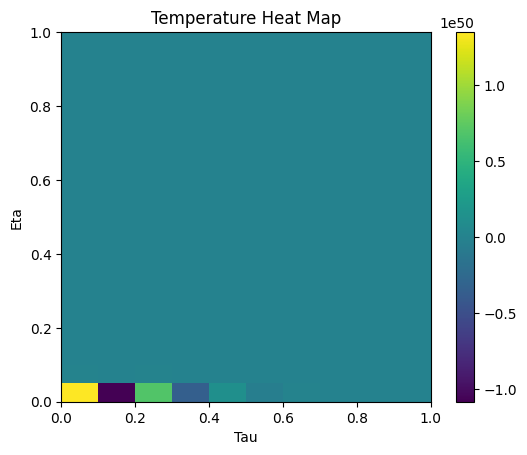

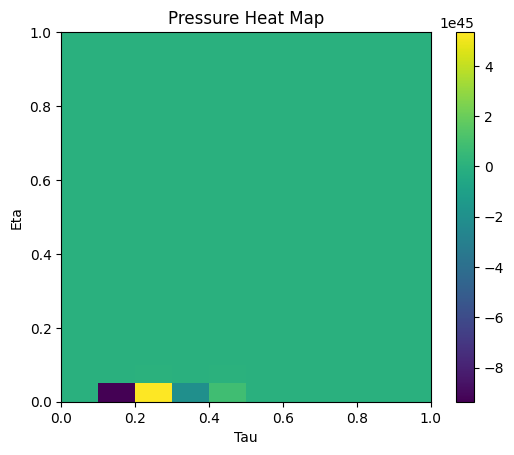

In [16]:
# Definición de variables y condiciones iniciales
N = 20  # Número de puntos en la dirección temporal
M = 10  # Número de puntos en la dirección vertical
eta = np.linspace(0, 1, M)  # Coordenada vertical adimensional
tau = np.linspace(0, 1, N)  # Coordenada temporal adimensional
deta = (eta[-1] - eta[0])/ M
dtau = (tau[-1] - tau[0])/ N
v = np.zeros((N, M))  # Velocidad adimensional
theta = np.zeros((N, M))  # Temperatura adimensional
Pi = np.zeros((N, M))  # Presión adimensional

# Condiciones iniciales
v[0, :] = 0.0  # Velocidad inicial cero
theta[0, :] = 0.0  # Temperatura inicial uniforme
Pi[0, :] = 1.0  # Presión inicial uniforme

# Simulación numérica
for i in range(N-1):
    for j in range(M-1):

        if i == 0:

            v[i+1, j] = v[i,j] + dtau * (
            - (1/(2 * Pi_d)) * (Pi[i, j+1] - Pi[i, j]) / deta
            - theta[i, j]
            - LAMBDA * v[i, j]** 2
            )
            
            theta[i+1, j] = theta[i, j] - dtau * (v[i+1, j] * ((theta[i, j+1] - theta[i, j]) / (deta)) 
                                                    - delta * ((theta[i, j-1] - 2 * theta[i, j] + theta[i, j+1]) / deta**2)
                                                    + gamma * (theta[i, j] - 1))
        
            if j == 0:
                Pi[i+1, M-1-j] = 1
            elif j == M-1:
                Pi[i+1, M-1-j] = Pi[i+1, M-j]
            else:    
                Pi[i+1, M-1-j] = Pi[i+1, M-j] - 2 * Pi_d * deta * (((v[i+1, j] - v[i, j]) / dtau) + theta[i+1, M-j] + LAMBDA * v[i+1, M-j]**2)

        else:

            v[i+1] = (1 / Pi_d) * np.sqrt(1 - Pi[i+1, 0])
         
            theta[i+1, j] = theta[i, j] - dtau * (v[i+1, j] * ((theta[i, j+1] - theta[i, j]) / (deta)) 
                                                        - delta * ((theta[i, j-1] - 2 * theta[i, j] + theta[i, j+1]) / deta**2)
                                                        + gamma * (theta[i, j] - 1))
            if j == 0:
                Pi[i+1, M-1-j] = 1
            elif j == M-1:
                Pi[i+1, M-1-j] = Pi[i+1, M-j]
            else:    
                Pi[i+1, M-1-j] = Pi[i+1, M-j] - 2 * Pi_d * deta * (((v[i+1, j] - v[i, j]) / dtau) + theta[i+1, M-j] + LAMBDA * v[i+1, M-j]**2)

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Heat map for theta
plt.figure()
plt.imshow(theta, cmap=cm.viridis, extent=[0, 1, 0, 1])
plt.xlabel('Tau')
plt.ylabel('Eta')
plt.title('Temperature Heat Map')
plt.colorbar()
plt.show()

# Heat map for Pi
plt.figure()
plt.imshow(Pi, cmap=cm.viridis, extent=[0, 1, 0, 1])
plt.xlabel('Tau')
plt.ylabel('Eta')
plt.title('Pressure Heat Map')
plt.colorbar()
plt.show()




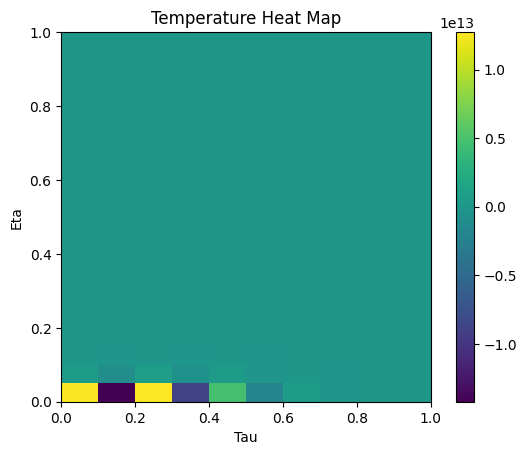

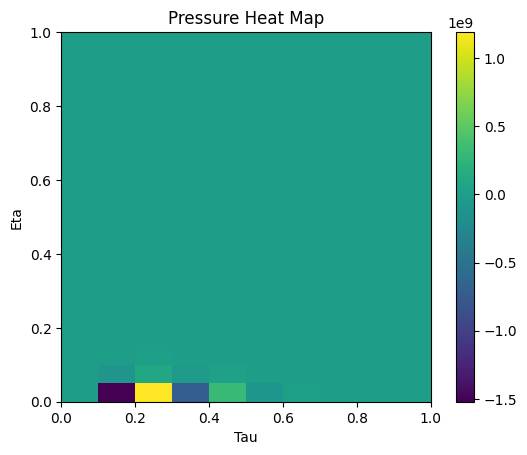

In [20]:
v_p = np.linspace(0, u_c, N)
theta[0, :] = 0.0  # Temperatura inicial uniforme
Pi[0, :] = 1.0  # Presión inicial uniforme

for i in range(1,N-1):
    for j in range(M-1):

        theta[i+1, j] = theta[i, j] - dtau * (v_p[i+1] * ((theta[i, j+1] - theta[i, j]) / (deta)) 
                                                        - delta * ((theta[i, j-1] - 2 * theta[i, j] + theta[i, j+1]) / deta**2)
                                                        + gamma * (theta[i, j] - 1))

        if j == 0:
                Pi[i+1, M-1-j] = 1
        elif j == M-1:
            Pi[i+1, M-1-j] = Pi[i+1, M-j]
        else:    
            Pi[i+1, M-1-j] = Pi[i+1, M-j] - 2 * Pi_d * deta * (((v_p[i+1] - v_p[i]) / dtau) + theta[i+1, M-j] + LAMBDA * v_p[i+1]**2)

# Heat map for theta
plt.figure()
plt.imshow(theta, cmap=cm.viridis, extent=[0, 1, 0, 1])
plt.xlabel('Tau')
plt.ylabel('Eta')
plt.title('Temperature Heat Map')
plt.colorbar()
plt.show()

# Heat map for Pi
plt.figure()
plt.imshow(Pi, cmap=cm.viridis, extent=[0, 1, 0, 1])
plt.xlabel('Tau')
plt.ylabel('Eta')
plt.title('Pressure Heat Map')
plt.colorbar()
plt.show()

In [21]:
print(u_c)

14.689996596323637


## Velocidad caracteristica de estado estacionario

In [35]:
u_e_p = ((rho_0 * g * Cp * beta * delta_T) / (2 * h_v * (1/2 + (lambda_f * L) / (8 * R)))) * (- 1 + np.sqrt(1 - ((4 * L * h_v**2 * (1/2 + (lambda_f * L)/(8 * R))) / (g * (rho_0 * Cp * beta * delta_T)**2))))
print(u_e_p)
u_e_n = ((rho_0 * g * Cp * beta * delta_T) / (2 * h_v * (1/2 + (lambda_f * L) / (8 * R)))) * (- 1 - np.sqrt(1 - ((4 * L * h_v**2 * (1/2 + (lambda_f * L)/(8 * R))) / (g * (rho_0 * Cp * beta * delta_T)**2))))
print(u_e_n)
print(h_v)

-5.710916626314761
-312.00213528033714
0.012497586662466184


In [38]:
h_v = (1.42 * ((delta_T / L)**(1/4)) / L)
u_e = (rho_0 * g * Cp * beta * delta_T)/(h_v * (1/2 + (lambda_f * L)/(8 * R)))
print(u_e)
print(h_v)

317.7130519066519
0.012497586662466184


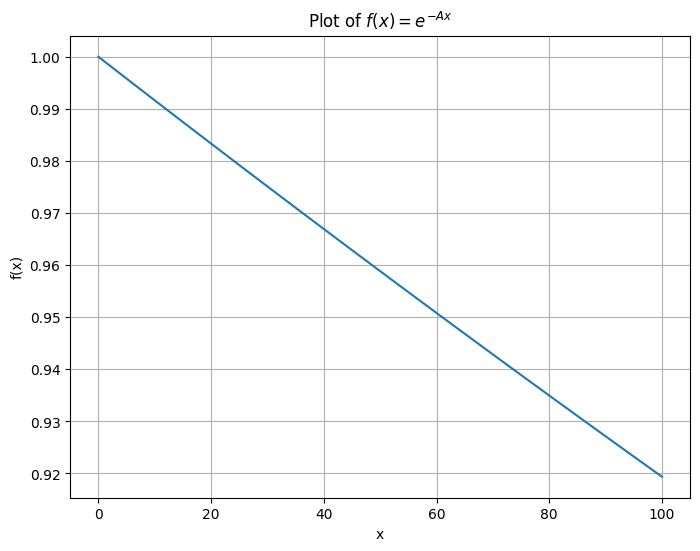

In [46]:
# Define the function parameters
A = h_v/(rho_0 * Cp * u_c) # Parameter A

# Create the x-axis
x = np.linspace(0, L, 100) # Range of x values

# Calculate the function values
f = np.exp(-A*x) # Evaluate the function f(x) = e^(-Ax)

# Plot the function
plt.figure(figsize=(8, 6))
plt.plot(x, f)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(r'Plot of $f(x) = e^{-Ax}$')
plt.grid()
plt.show()


In [49]:
T_f = (0.92 * T_a + 0.08 * T_w) 
print(T_f - 273)

24.80000000000001


In [50]:
u_e = (rho_0 * g * Cp * beta * (T_f - T_a))/(h_v * (1/2 + (lambda_f * L)/ (8 *R)))
print(u_e)

25.417044152532213
